In [1]:
import json
import os
from collections import namedtuple, defaultdict
from datetime import datetime
from dataclasses import dataclass
import re

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

import nltk
nltk.download('punkt')

init_notebook_mode(connected=True)
%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Airat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
Msg = namedtuple('Msg', ['date', 'sender', 'msg']) # sender: 0 if me else 1

@dataclass
class Chat:
    name_in_file: str
    name: str
    msgs: list[Msg]
    
BaseObject = dict[str, Chat]

def get_export_filenames(dir_name) -> list[str]:
    files = os.listdir(dir_name)
    return files

def _create_chat(chat_filename, chat_json) -> Chat:
    name = chat_json['name']
    from_id = 'user' + str(chat_json['id'])
    msg_list = []
    for msg_json in chat_json['messages']:
        if not msg_json['text'] or not isinstance(msg_json['text'], str):
            continue
        if msg_json['type'] == 'message':
            sender = 1 if msg_json['from_id'] == from_id else 0
            msg_list.append(Msg(datetime.fromtimestamp(int(msg_json['date_unixtime'])), sender, msg_json['text']))
    return Chat(chat_filename, name, msg_list)

def create_chat_from_json(path, name: str = 'not-spec'):
    with open(path, encoding='utf-8') as f:
        return _create_chat(name, json.load(f))

def create_base_data_structure(dir_name) -> BaseObject:
    files = get_export_filenames(dir_name)
    dict_of_chats = dict()
    for file in files:
        dict_of_chats[file[:-5]] = create_chat_from_json(os.path.join(dir_name, file), file[:5])
    return dict_of_chats

def pull_my_messages(base: BaseObject) -> list[datetime, str]:
    res = []
    for chat in base.values():
        for msg in chat.msgs:
            if msg.sender == 0:
                res.append((msg.date, nltk.word_tokenize(msg.msg.lower(), language='russian')))
    res.sort(key=lambda x: x[0])
    return res

In [4]:
class Analyse:
    def total_num_of_msgs(base: BaseObject):
        table = []
        for name, chat in base.items():
            total_len = len(chat.msgs)
            me_len = sum(msg.sender == 0 for msg in chat.msgs)
            them_len = total_len - me_len
            table.append((name, total_len, me_len, them_len))
        table.sort(key=lambda x: x[1], reverse=True)
        print(f'{"name":<8} {"total":<8} {"me":<8} {"them":<8}')
        for row in table:
            print('{:<8} {:<8} {:<8} {:<8}'.format(*row))

    def all_chats_chatting_freq(chats: BaseObject):
        fig = go.Figure()
        msgs_per_day = dict()
        for chat_name, chat in chats.items():
            this_dict = defaultdict(int)
            for msg in chat.msgs:
                this_dict[datetime.date(msg.date)] += 1
            dates, nums = zip(*this_dict.items())
            msgs_per_day[chat_name] = np.mean(nums), np.std(nums)
            fig.add_trace(go.Scatter(x=dates, y=nums,
                        mode='lines+markers',
                        name=chat_name, marker={'size':3, 'opacity':0.9}, line = dict(width=1, dash='dot')))
        fig.update_xaxes(gridcolor='gray', minor_griddash="dot")
        fig.update_yaxes(gridcolor='gray', minor_griddash="dot")
        fig.show()
        return msgs_per_day

    def by_weekday(chat: Chat):
        wd_freq = defaultdict(int)
        for msg in chat.msgs:
            wd_freq[msg.date.weekday()] += 1
        WD = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        vals_correct_order = [wd_freq[i] for i in range(7)]
        plt.bar(WD, vals_correct_order)
        plt.show()
    
    def waiting_time_stats(chat: Chat, ignore_threshold=6*3600):
        me = [] # i am waiting
        them = [] # they are waiting
        for msg1, msg2 in zip(chat.msgs[:-1], chat.msgs[1:]):
            if not msg1.sender ^ msg2.sender:
                continue
            delta = (msg2.date - msg1.date).total_seconds()
            if delta > ignore_threshold:
                continue
            if msg2.sender == 1:
                me.append(delta)
            else:
                them.append(delta)
        me_mean = np.mean(me); me_std = np.std(me); me_median = np.median(me)
        them_mean = np.mean(them); them_std = np.std(them); them_median = np.median(them)
        print(f'I waited ({me_mean:.1f} ± {me_std:.1f}) sec with median {me_median} sec.')
        print(f'{chat.name_in_file.capitalize()} waited ({them_mean:.1f} ± {them_std:.1f}) sec with median {them_median} sec.')
    

    def chatting_freq(chat: Chat, words: list[str] = [], by_regex=''):
        msgs_per_day_me = defaultdict(int)
        msgs_per_day_them = defaultdict(int)
        for msg in chat.msgs:
            if by_regex and not re.search(by_regex, msg.msg, re.I):
                continue
            increment = 1
            if words:
                increment = sum(msg.msg.lower().count(w.lower()) for w in words)
                if not increment: continue
            
            if msg.sender == 1:
                msgs_per_day_them[datetime.date(msg.date)] += increment
            else:
                msgs_per_day_me[datetime.date(msg.date)] += increment

        dates_me, nums_me = zip(*msgs_per_day_me.items())
        dates_them, nums_them = zip(*msgs_per_day_them.items())

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=dates_me, y=nums_me,
                    mode='lines+markers',
                    name='me', marker={'size':5, 'opacity':0.9}, line = dict(width=1, dash='dot')))
        fig.add_trace(go.Scatter(x=dates_them, y=nums_them,
                    mode='lines+markers',
                    name='them', marker={'size':5, 'opacity':0.9}, line = dict(width=1, dash='dot')))
        fig.update_xaxes(gridcolor='gray', minor_griddash="dot")
        fig.update_yaxes(gridcolor='gray', minor_griddash="dot")
        print(f'Total: {sum(nums_me)} (me), {sum(nums_them)} (them).')
        fig.show()

    def average_msg_len(chat: Chat, show_hist=False):
        me, them = [], []
        for msg in chat.msgs:
            if msg.sender == 1:
                them.append(len(msg.msg))
            else:
                me.append(len(msg.msg))
        print(f'Average message length:\n{np.mean(me):.2f} ± {np.std(me):.2f} (me);\n{np.mean(them):.2f} ± {np.std(them):.2f} (them).')
        # print(np.median(me), np.median(them))
        if not show_hist:
            return
        plt.hist(me, bins=25, alpha=0.5, label='me')
        plt.hist(them, bins=25, alpha=0.5, label='them')
        plt.xlim(0, 140)
        plt.legend()
        plt.show()
    
    def time_of_the_day_hist(chat: Chat):
        msgs_me = defaultdict(int)
        msgs_them = defaultdict(int)
        for msg in chat.msgs:
            if msg.sender == 0:
                msgs_me[msg.date.hour] += 1
            else:
                msgs_them[msg.date.hour] += 1
        
        tmp = list(msgs_me.items())
        tmp.sort(key=lambda x: x[0])
        hours_me, nums_me = zip(*tmp)
        plt.bar(hours_me, nums_me, alpha=0.5, label='me')
        tmp = list(msgs_them.items())
        tmp.sort(key=lambda x: x[0])
        hours_me, nums_me = zip(*tmp)
        plt.bar(hours_me, nums_me, alpha=0.5, label='them')
        plt.legend()
        plt.xticks(range(24))
        plt.grid()
        plt.show()

    def word_usage_by_me(my_msgs: list[datetime, list[str]], word='', relative=False):
        msgs_per_day = defaultdict(int)
        msgs_per_day_total = defaultdict(int)
        for day_time, words in my_msgs:
            if word:
                msgs_per_day[datetime.date(day_time)] += words.count(word)
            msgs_per_day_total[datetime.date(day_time)] += len(words)
            total_uses = sum((msgs_per_day if word else msgs_per_day_total).values())
        
        if relative:
            for key in msgs_per_day.keys():
                msgs_per_day[key] /= msgs_per_day_total[key]
        
        date_num_tuples = sorted((msgs_per_day if word else msgs_per_day_total).items(), key=lambda x: 0)
        dates, nums = [], []
        for d, n in date_num_tuples:
            dates.append(d); nums.append(n)
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=dates, y=nums, mode='lines+markers', marker={'size': 5, 'opacity': 0.9}, line = dict(width=1, dash='dot')))
        fig.update_xaxes(gridcolor='gray', minor_griddash="dot")
        fig.update_yaxes(gridcolor='gray', minor_griddash="dot")
        print(f'Total # words used: {total_uses}.')
        fig.show()


In [5]:
chats = create_base_data_structure('exports')

In [6]:
Analyse.total_num_of_msgs(chats)

name     total    me       them    
diana    335348   176274   159074  
lika     36149    18159    17990   
leha     28595    14525    14070   
azat     18125    10119    8006    
zu       14165    6827     7338    
damir    10492    5752     4740    
martina  9533     4783     4750    
zulya    6832     3796     3036    
arina    6309     3589     2720    
mom      6289     3464     2825    
nikita   5304     2872     2432    
dinar    4577     2694     1883    
lion     2979     1811     1168    
dad      1847     1114     733     
dina     1687     944      743     
artem    169      97       72      


In [7]:
msgs_per_day = Analyse.all_chats_chatting_freq(chats)
print('{:>8}  {}'.format('name', 'messages per day'))
for chat_name, meanstd in msgs_per_day.items():
    print('{:>8}: ({:.1f} ± {:.1f})'.format(chat_name, *meanstd))

    name  messages per day
   arina: (43.8 ± 52.3)
   artem: (9.9 ± 12.9)
    azat: (62.3 ± 134.0)
     dad: (7.2 ± 8.1)
   damir: (58.0 ± 70.4)
   diana: (223.0 ± 207.8)
    dina: (33.7 ± 30.3)
   dinar: (17.1 ± 40.1)
    leha: (56.4 ± 89.9)
    lika: (77.7 ± 121.7)
    lion: (13.1 ± 18.3)
 martina: (30.8 ± 33.0)
     mom: (11.4 ± 13.7)
  nikita: (15.9 ± 23.8)
      zu: (289.1 ± 495.6)
   zulya: (36.1 ± 51.8)


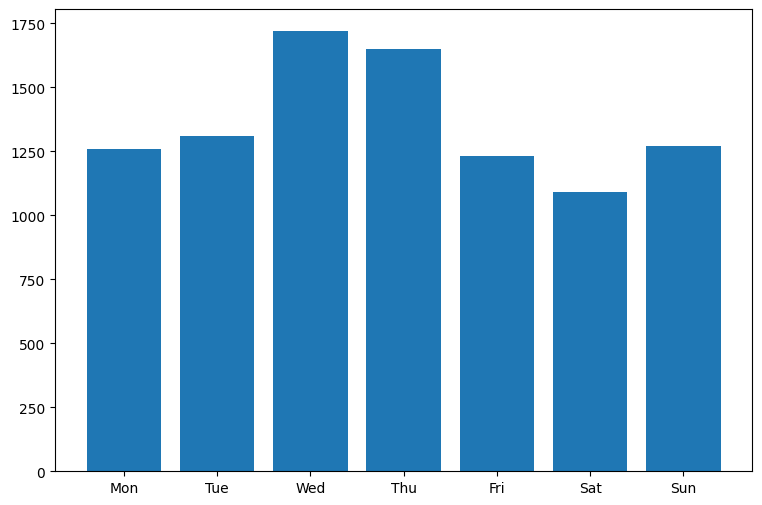

In [11]:
Analyse.by_weekday(chat=chats['martina'])

In [12]:
Analyse.waiting_time_stats(chat=chats['lion'])

I waited (1037.8 ± 3121.2) sec with median 24.5 sec.
Lion. waited (503.2 ± 1923.4) sec with median 17.0 sec.


Average message length:
17.75 ± 20.05 (me);
22.38 ± 35.05 (them).


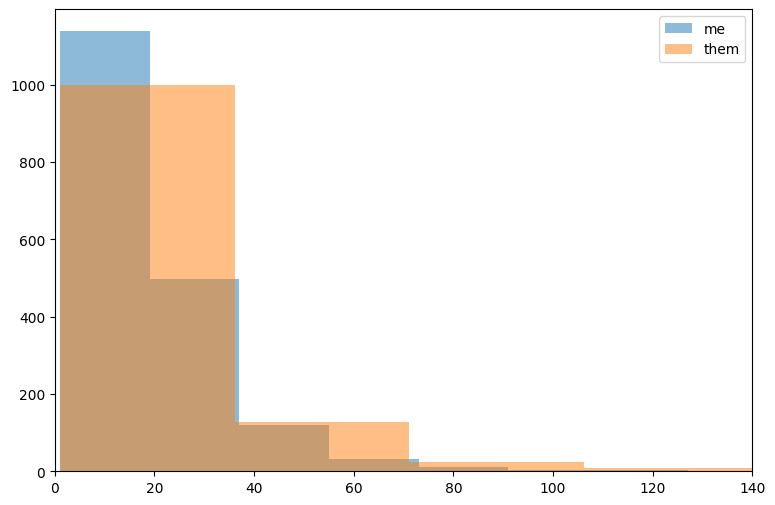

In [15]:
Analyse.average_msg_len(
    chat=chats['lion'],
    show_hist=True
)

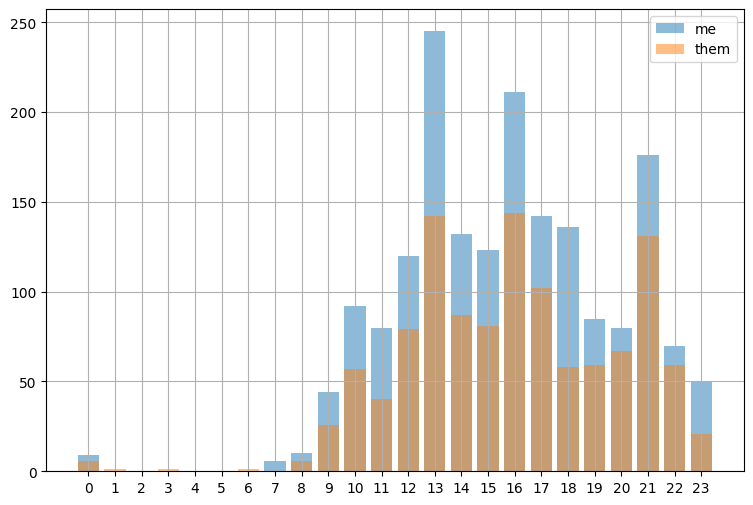

In [16]:
Analyse.time_of_the_day_hist(chat=chats['lion'])

In [17]:
Analyse.chatting_freq(chat=chats['diana'], words=[], by_regex=r'')

Total: 176274 (me), 159074 (them).
